# BUDGET CLASSIFICATION USING DECISION TREES

_**Classifying budget level of movies for production companies based on parameters such as country, director, genre, expected revienue, main star, etc.**_
Data card is available at https://www.kaggle.com/datasets/danielgrijalvas/movies.

In [2]:
# Imports required packages

import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

## Data Collection

In [4]:
# Loads dataset from csv file
movies = pd.read_csv("../Data/movies.csv")

In [5]:
# Displays few of the data samples
display(movies.head())

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


## Exploratory Data Analysis (EDA)

In [7]:
# Checks for basic information about the dataset

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


**Observations from the basic information are**

- Features are of both numeric and non-numeric
- Most features have missing values
- Important attribute 'budget' has quite a few missing values

In [9]:
# Checks for the descriptive statistics of the dataset
movies.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [10]:
# Checks for attributes having missing values in the dataset
movies.isnull().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

As **_budget_** will be considered as dependant attribute in this experiment, instances having missing values for this attribute need to be removed.

**Checks for the values in each categorical attribute**

In [13]:
movies.rating.value_counts()

rating
R            3697
PG-13        2112
PG           1252
Not Rated     283
G             153
Unrated        52
NC-17          23
TV-MA           9
TV-PG           5
X               3
Approved        1
TV-14           1
Name: count, dtype: int64

In [14]:
movies.genre.value_counts()

genre
Comedy       2245
Action       1705
Drama        1518
Crime         551
Biography     443
Adventure     427
Animation     338
Horror        322
Fantasy        44
Mystery        20
Thriller       16
Family         11
Sci-Fi         10
Romance        10
Western         3
Musical         2
Music           1
History         1
Sport           1
Name: count, dtype: int64

In [15]:
movies.released.value_counts()

released
October 4, 1991 (United States)       9
May 17, 2019 (United States)          9
February 14, 1986 (United States)     9
October 21, 1988 (United States)      8
October 11, 2002 (United States)      8
                                     ..
December 25, 2020 (United States)     1
August 30, 2019 (United Kingdom)      1
December 20, 2019 (China)             1
September 27, 2019 (United States)    1
August 8, 2019 (Germany)              1
Name: count, Length: 3414, dtype: int64

As **_released_** attribute contains country in which the moview was released, the name of the releasing country should be extracted.

In [17]:
movies.director.value_counts()

director
Woody Allen         38
Clint Eastwood      31
Directors           28
Steven Spielberg    27
Ron Howard          24
                    ..
Gary Sinyor          1
Chris Roberts        1
Hiroyuki Okiura      1
Martha Fiennes       1
Mark Illsley         1
Name: count, Length: 2949, dtype: int64

<Axes: xlabel='director'>

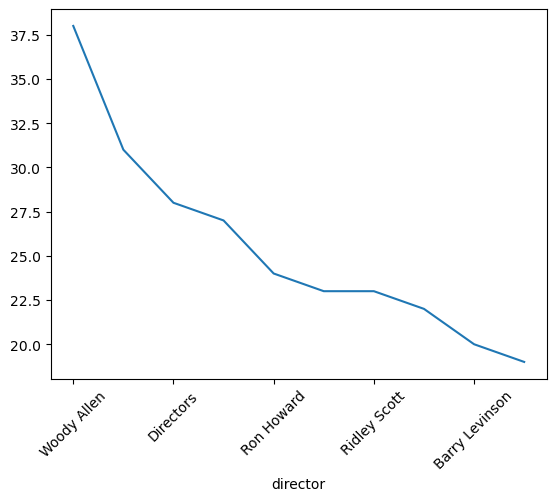

In [18]:
# As shown above, dataset contains movies directed by 2949 unique directors.
# Few of the top directors' movie counts are show below.

movies.director.value_counts()[:10].plot(rot=45)

In [19]:
# Top directors' names are stored into a list for later use
top_directors = movies.director.value_counts()[:10].index.tolist()

# All other directors are named as 'Other'
top_directors.append("Other")

In [20]:
movies.writer.value_counts()

writer
Woody Allen         37
Stephen King        31
Luc Besson          26
John Hughes         25
David Mamet         15
                    ..
Roxanne Benjamin     1
Chao Wang            1
Su-jin Park          1
Mark Bramble         1
Noel Ashman          1
Name: count, Length: 4535, dtype: int64

<Axes: xlabel='writer'>

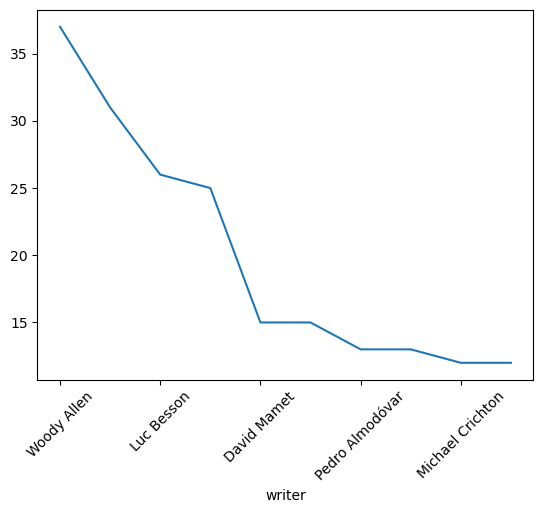

In [21]:
# As shown above, dataset contains movies written by 4535 unique writers.
# Few of the top writers' movie counts are show below.

movies.writer.value_counts()[:10].plot(rot=45)

In [22]:
# Top wrters' names are stored into a list for later use
top_writers = movies.writer.value_counts()[:10].index.tolist()

# All other writers are named as 'Other'
top_writers.append("Other")

In [23]:
movies.star.value_counts()

star
Nicolas Cage           43
Tom Hanks              41
Robert De Niro         41
Denzel Washington      37
Tom Cruise             34
                       ..
Bonnie Langford         1
Francesco Di Napoli     1
Kartik Aaryan           1
Juan Barberini          1
Michael Roark           1
Name: count, Length: 2814, dtype: int64

<Axes: xlabel='star'>

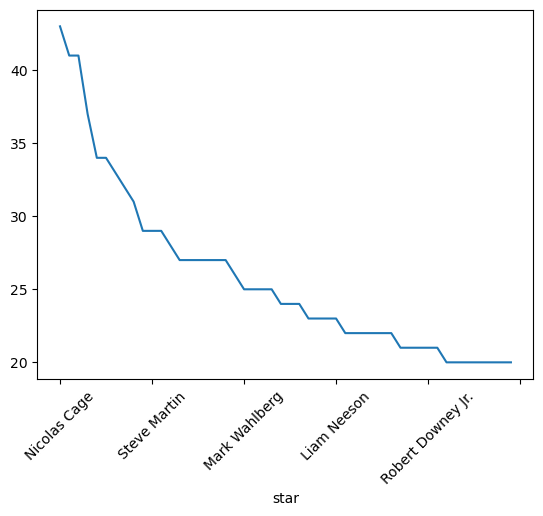

In [24]:
# As shown above, dataset contains movies acted by 2814 unique stars.
# Few of the top stars' movie counts are show below.

movies.star.value_counts()[:50].plot(rot=45)

In [25]:
# Top stars' names are stored into a list for later use
top_stars = movies.star.value_counts()[:50].index.tolist()

# All other stars are named as 'Other'
top_stars.append("Other")

In [26]:
movies.country.value_counts()

country
United States                     5475
United Kingdom                     816
France                             279
Canada                             190
Germany                            117
Australia                           92
Japan                               81
India                               62
Italy                               61
Spain                               47
Hong Kong                           45
Ireland                             43
China                               40
South Korea                         35
Denmark                             32
Sweden                              25
New Zealand                         25
Mexico                              22
West Germany                        12
Netherlands                         12
Norway                              12
Iran                                10
Switzerland                         10
Russia                               8
Belgium                              8
South Africa     

In [27]:
# Top countries' names are stored into a list for later use
top_countries = movies.country.value_counts()[:5].index.tolist()

# All other countries are named as 'Other'
top_countries.append("Other")

In [28]:
movies.company.value_counts()

company
Universal Pictures          377
Warner Bros.                334
Columbia Pictures           332
Paramount Pictures          320
Twentieth Century Fox       240
                           ... 
Oxford Film Company           1
Greek Film Center             1
Republic Pictures (II)        1
Farabi Cinema Foundation      1
NDF International             1
Name: count, Length: 2385, dtype: int64

<Axes: xlabel='company'>

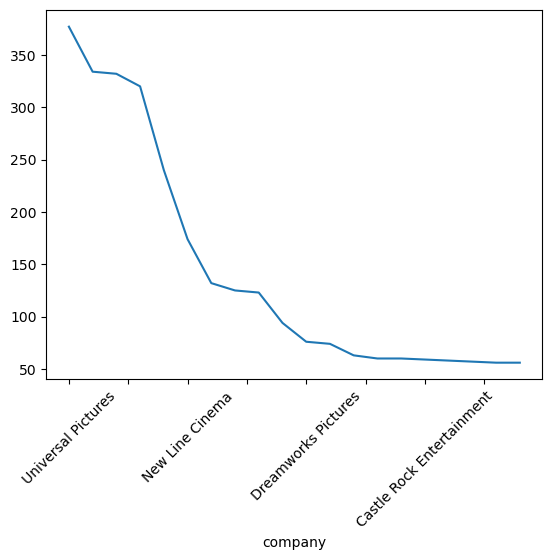

In [29]:
# As shown above, dataset contains movies produced by 2385 unique companies.
# Few of the top companies' movie counts are show below.

movies.company.value_counts()[:20].plot(rot=45)

In [30]:
# Top companies' names are stored into a list for later use
top_companies = movies.company.value_counts()[:20].index.tolist()

# All other companies are named as 'Other'
top_companies.append("Other")

## Data Preparation

### Checking for Duplicate Instances

In [33]:
# Drops duplicate instances, if any
movies.drop_duplicates(keep='first', inplace=True)

### Removing Non-required Attributes

In [35]:
# Drops attribute 'name' from the dataset as it is an 'identifier'-like

movies.drop(["name"], axis=1, inplace=True)

### Removing Instances with Missing Values

In [37]:
# Deletes the instances for missing 'budget' values. Other instances with missing values also
# get deleted considering these instances are just tiny portion of the dataset
# 'ranting': 1.0%, 'released': 0.02%, 'score': 0.03%, 'votes': 0.03%, 'writer': 0.03%,
# 'star': 0.01%, 'country': 0.03%, 'gross': 2%, 'company': 0.2%, 'runtime': 0.05%

movies.dropna(inplace=True)

In [38]:
# Checks the shape of the dataset after removing instances with missing values

movies.shape

(5421, 14)

### Updating Specific Categorical Attributes

In [40]:
# Attribute 'released' constains combined information for both movie releasing date and releasing country.
# Only releasing country gets extracted considering releasing date to be closed to values in attribute 'year'.

movies.released = movies.released.apply(lambda r: re.findall(r'\((.*?)\)', r)[0])

In [41]:
# Checks the occurances of countries
movies.released.value_counts()

released
United States           5076
United Kingdom            87
France                    41
Germany                   25
Australia                 14
Spain                     14
Canada                    13
Japan                     12
Italy                     10
South Korea               10
Denmark                    9
Brazil                     9
Argentina                  7
Russia                     6
China                      6
Netherlands                6
Israel                     6
Greece                     5
Singapore                  4
South Africa               4
Ireland                    4
Norway                     4
Iceland                    4
Hong Kong                  4
India                      3
Taiwan                     3
Sweden                     3
Mexico                     3
Belgium                    2
Portugal                   2
Poland                     2
Iran                       2
Bulgaria                   2
Lebanon                    2
Turke

In [42]:
# As 'United States' holds more than 90% of all the movie releasing countries,
# all other countries are considered as 'Other' as they hold a tiny portion of share for this attribute.

top_releasing_countries = ["United States", "Other"]

**Updates all the specific attributes with their _top_ values found in the previous steps**

In [44]:
movies.released = movies.released.apply(
    lambda r: r if (top_releasing_countries.count(r) > 0) else "Other")

In [45]:
movies.director = movies.director.apply(
    lambda d: d if (top_directors.count(d) > 0) else "Other")

In [46]:
movies.writer = movies.writer.apply(
    lambda w: w if (top_writers.count(w) > 0) else "Other")

In [47]:
movies.star = movies.star.apply(
    lambda s: s if (top_stars.count(s) > 0) else "Other")

In [48]:
movies.country = movies.country.apply(
    lambda c: c if (top_countries.count(c) > 0) else "Other")

In [49]:
movies.company = movies.company.apply(
    lambda c: c if (top_companies.count(c) > 0) else "Other")

### Preparing Target

<Axes: ylabel='Frequency'>

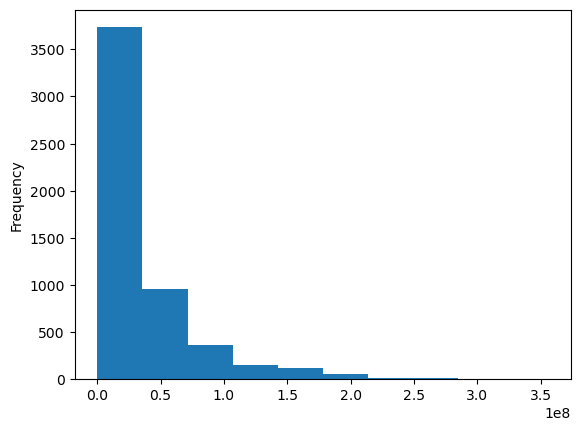

In [51]:
# Checks for the budget distribution
movies.budget.plot(kind='hist')

In [52]:
# Segmenting budget values into bins or labels for equal distribution during 
# train-test dataset seperation and to be used as target in this classification experiment.
movies["budget_level"] = pd.cut(movies.budget,
       bins=[0., 25000000., 50000000., 75000000., 100000000., 125000000., 150000000., 175000000., 200000000., 225000000., np.inf],
       labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [53]:
# Drops the 'budget' attribute as no more required after binning
movies.drop(["budget"], axis=1, inplace=True)

### Preparing Test Dataset

In [105]:
# Splits dataset into train and test dataset
X_train, X_test = train_test_split(
    movies, test_size=0.20, random_state=42, stratify=movies["budget_level"])

In [107]:
# Seperates target attribute from train dataset
y_train = X_train.budget_level.copy()
X_train.drop(["budget_level"], axis=1, inplace=True)

In [109]:
# Seperates target attribute from test dataset
y_test = X_test.budget_level.copy()
X_test.drop(["budget_level"], axis=1, inplace=True)

## Modeling

In [113]:
# Stores names of the categorical attributes for later use in pipeline
categorical_attributes = ["rating", "genre", "released", "director", "writer", "star", "country", "company"]

In [115]:
# Configures transformation for categorical attributes
column_transformer = ColumnTransformer([
    # To call categorical pipeline for categorical attribute
    ("categorical_pipeline", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_attributes)])

In [117]:
# Configures model pipeline containing attributes transformer and model
model_pipeline = Pipeline([
    ("data_transformation", column_transformer),
    ("modeling", RandomForestClassifier(oob_score=True, random_state=42))
])

In [119]:
# Fits the model over pipeline
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_transformation',
                 ColumnTransformer(transformers=[('categorical_pipeline',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rating', 'genre',
                                                   'released', 'director',
                                                   'writer', 'star', 'country',
                                                   'company'])])),
                ('modeling',
                 RandomForestClassifier(oob_score=True, random_state=42))])

### Prediction and Performance Analysis

**Predicting on train dataset and performing performance**

In [129]:
# Makes predictions on train data
y_train_predictions = model_pipeline.predict(X_train)

# Shows few of the predictions
y_train_predictions

array([3, 1, 1, ..., 1, 1, 2])

In [131]:
# Performs accuracy score against train data
accuracy_score(y_train, y_train_predictions)

0.7659132841328413

**Predicting on test dataset and performing performance**

In [121]:
# Makes predictions on test data
y_test_predictions = model_pipeline.predict(X_test)

In [123]:
# Shows few of the predictions
y_test_predictions

array([1, 1, 1, ..., 1, 3, 2])

In [125]:
# Performs accuracy score against test data
accuracy_score(y_test, y_test_predictions)

0.5741935483870968